In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [2]:
TRAIN_DIR = "horse-or-human-dataset/train"
VAL_DIR = "horse-or-human-dataset/validation"

training_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size = (150, 150),
    batch_size = 32,
    label_mode = "binary"
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size = (150, 150),
    batch_size = 32,
    label_mode = "binary"
)

Found 1027 files belonging to 2 classes.
Found 256 files belonging to 2 classes.


In [3]:
training_dataset_final = (training_dataset.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE))
validation_dataset_final = (validation_dataset.cache().prefetch(tf.data.AUTOTUNE))

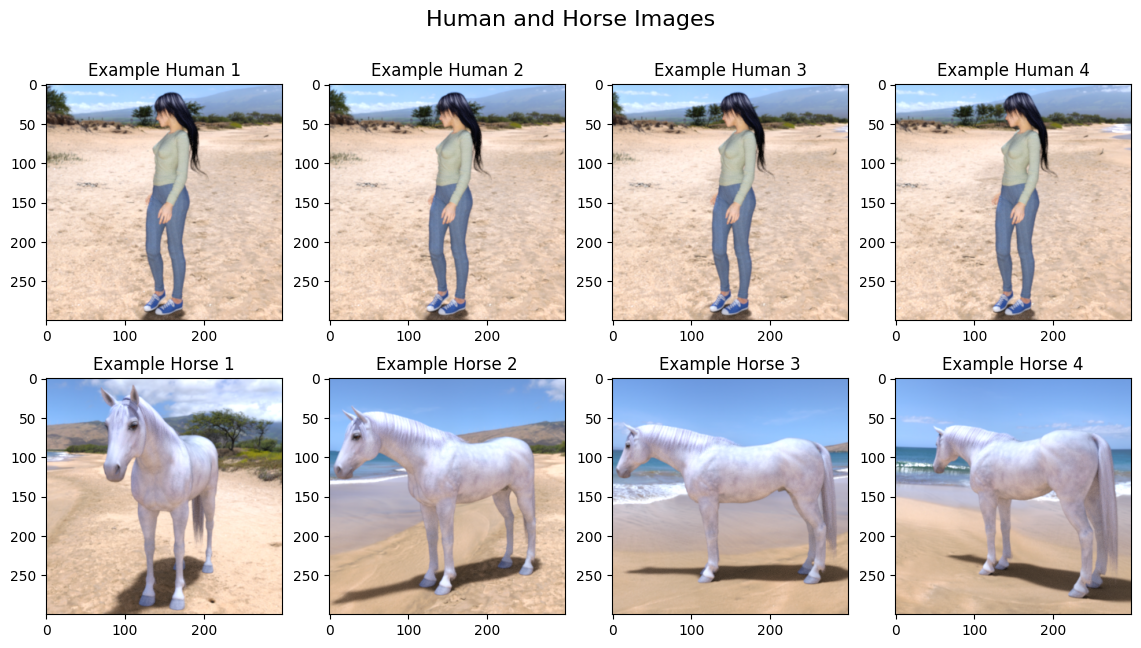

In [4]:
HUMANS_DIR = f"{TRAIN_DIR}/humans"
HORSES_DIR = f"{TRAIN_DIR}/horses"

humans_filenames = os.listdir(HUMANS_DIR)
horses_filenames = os.listdir(HORSES_DIR)

humans_images = [f"{HUMANS_DIR}/{filename}" for filename in humans_filenames]
horses_images = [f"{HORSES_DIR}/{filename}" for filename in horses_filenames]

fig, axes = plt.subplots(2, 4, figsize=(14, 7))
fig.suptitle('Human and Horse Images', fontsize=16)

# Plot the first 4 images of each class
for i, human_image in enumerate(humans_images[:4]):
    img = tf.keras.utils.load_img(human_image)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Example Human {i+1}')

for i, horse_image in enumerate(horses_images[:4]):
    img = tf.keras.utils.load_img(horse_image)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Example Horse {i+1}')
plt.show()


In [5]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['accuracy']>0.999:
            self.model.stop_training = True
            print("\nReached 99.9% accuracy so cancelling training!")

In [6]:
def preprocess(image, label):
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image, label

training_dataset_scaled = training_dataset_final.map(preprocess)
validation_dataset_scaled = validation_dataset_final.map(preprocess)

In [7]:
LOCAL_WEIGHTS = "model/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

pretrained_model = InceptionV3(
    include_top = False,
    input_shape = (150, 150, 3),
    weights = LOCAL_WEIGHTS
)
pretrained_model.trainable = False

In [8]:
last_layer = pretrained_model.get_layer("mixed7")
last_output = last_layer.output

print(f"last layer output shape : {last_output.shape}")

last layer output shape : (None, 7, 7, 768)


In [9]:
x = Flatten()(last_output)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=pretrained_model.input, outputs=x)

In [10]:
model.compile(
    loss = BinaryCrossentropy,
    optimizer = Adam(0.0001),
    metrics = ["accuracy"]
)

In [11]:
history = model.fit(
    training_dataset_scaled,
    epochs = 5,
    validation_data = validation_dataset_scaled,
)

Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 404ms/step - accuracy: 0.8848 - loss: 0.1776 - val_accuracy: 1.0000 - val_loss: 0.0041
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 1.0000 - loss: 7.8351e-04 - val_accuracy: 1.0000 - val_loss: 0.0042
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 353ms/step - accuracy: 1.0000 - loss: 1.5692e-04 - val_accuracy: 0.9961 - val_loss: 0.0103
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 505ms/step - accuracy: 1.0000 - loss: 1.0113e-04 - val_accuracy: 0.9922 - val_loss: 0.0120
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 569ms/step - accuracy: 1.0000 - loss: 7.8089e-05 - val_accuracy: 0.9922 - val_loss: 0.0130


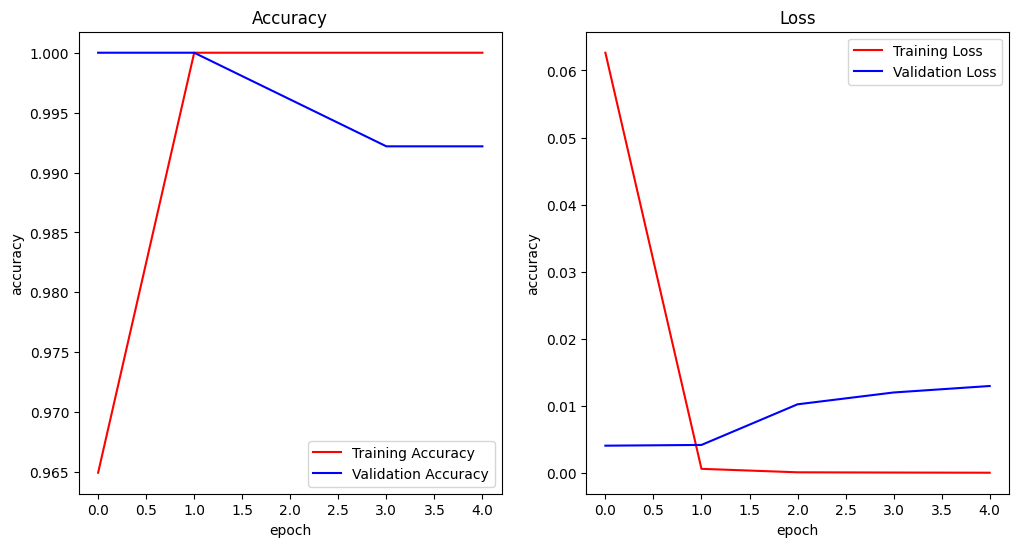

In [12]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(epochs, acc, "r", label="Training Accuracy")
ax[0].plot(epochs, val_acc, "b", label="Validation Accuracy")
ax[0].legend()
ax[0].set_title("Accuracy")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("accuracy")

ax[1].plot(epochs, loss, "r", label="Training Loss")
ax[1].plot(epochs, val_loss, "b", label="Validation Loss")
ax[1].legend()
ax[1].set_title("Loss")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("accuracy")
plt.show()